In [71]:
# Import library
# http://ufldl.stanford.edu/wiki/index.php/Independent_Component_Analysis
# http://ufldl.stanford.edu/tutorial/unsupervised/ICA/
# http://ufldl.stanford.edu/tutorial/unsupervised/ExerciseRICA/
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [102]:
# Read the Data and Shuffle it and Set and center it 
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import rescale, resize
dataset = fetch_olivetti_faces(shuffle=True)
train_data  = dataset.data.reshape(400,64,64)
print('---- Before Centering -------')
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

shuffle_index = np.random.permutation(len(train_data))
train_data = train_data[shuffle_index]

# print('---- After Centering and reshaping -------')
# train_data  = (train_data-train_data.mean(1)[:,np.newaxis]).reshape(400,64,64)
# print(train_data.shape)
# print(train_data.min(),train_data.max())
# print(train_data.mean(),train_data.std())

---- Before Centering -------
(400, 64, 64)
0.0 1.0
0.54704237 0.17251529


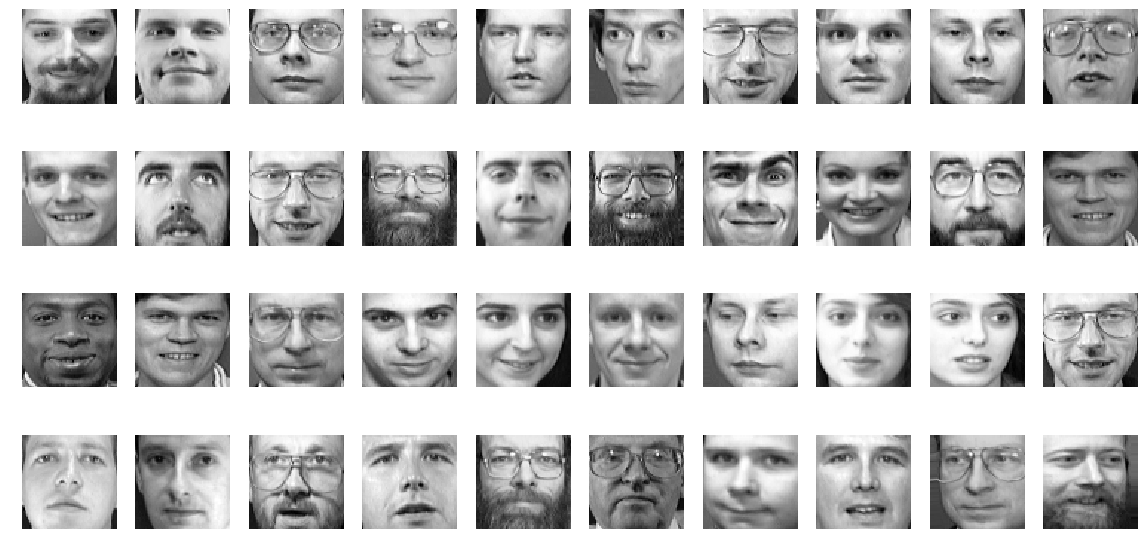

In [103]:
# show the image of the faces
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(train_data[i-1],cmap='gray')
plt.show()

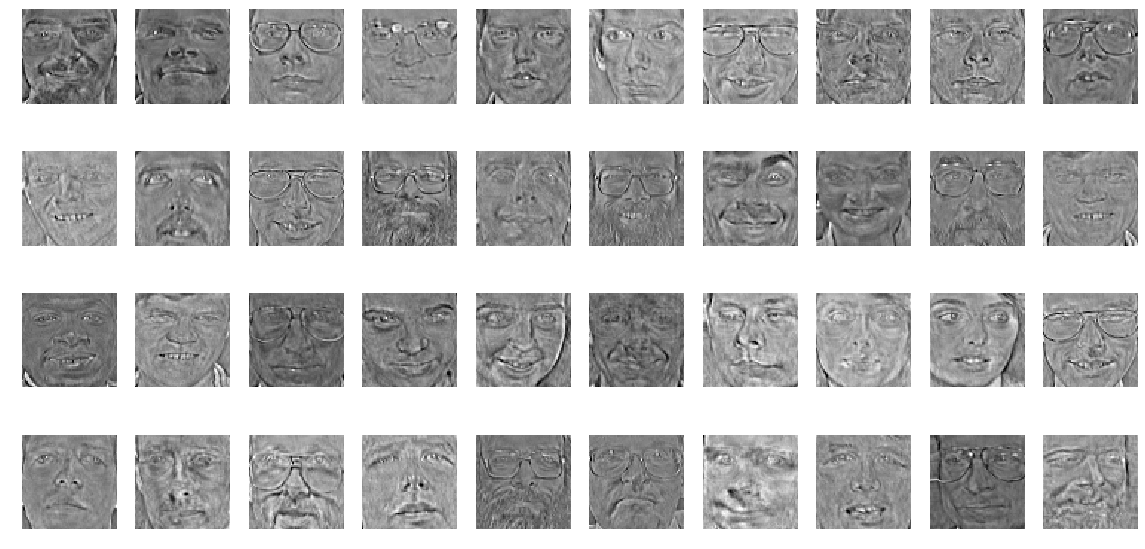

In [104]:
# Check ZCA whiten the data and center
def fit(X):
    mean_data = np.mean(X, axis=0)
    X -= mean_data
    sigma = np.dot(X.T,X) / X.shape[1]
    from scipy import linalg as LA
    U, S, V = LA.svd(sigma)
    tmp = np.dot(U, np.diag(1/np.sqrt(S)))
    components_ = np.dot(tmp, U.T)
    return X.dot(components_)
zca_data = fit(train_data.reshape(400,-1).T).T.reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_data[i-1],cmap='gray')
plt.show()

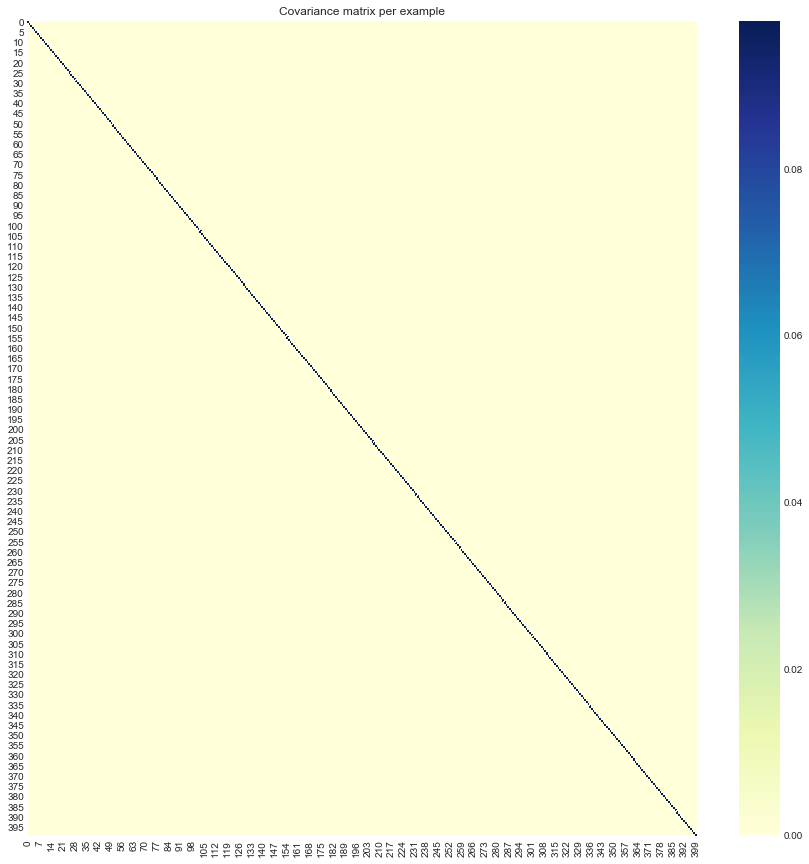

In [105]:
# show co-variance matrix
plt.figure(figsize=(15,15))
sns.heatmap(np.cov(zca_data.reshape(400,-1)),cmap="YlGnBu")
plt.title('Covariance matrix per example')
plt.show()

In [343]:
# create class
class Reconstruction_ICA():
    
    def __init__(self,inc,outc,seed=2):
        self.w = tf.Variable(tf.random_normal(shape=[outc,inc],stddev=0.05,dtype=tf.float64,seed=seed))
#         self.w = tf.Variable(tf.random_uniform(shape=[outc,inc],dtype=tf.float64,seed=seed))

        self.m = tf.Variable(tf.zeros_like(self.w))
        self.v = tf.Variable(tf.zeros_like(self.w))
    def getw(self): return self.w
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_rica(self,eps = 1e-10):
        
        #  ===== Calculate the Cost =======        
        cost_sparse = tf.sqrt(self.layer ** 2 + eps) # Relaxed L1 basically l2
        cost_spare_mean = lamda_val * tf.reduce_mean(cost_sparse)
        cost_recon  = tf.matmul(tf.transpose(self.w),self.layer)-self.input
        cost_spare_sum = 0.5 * tf.reduce_mean(cost_recon ** 2 )

        #  ===== Weight Update =====      
        grad_w_sparse = tf.matmul(lamda_val * (0.5) * (1.0/cost_sparse.shape[0].value) * \
                           (1.0/cost_sparse),tf.transpose(self.input))
        
        grad_w_recon = (tf.matmul(self.layer,tf.transpose(cost_recon)) + \
                       tf.matmul(tf.matmul(self.w,cost_recon),tf.transpose(self.input)))*(1.0/cost_recon.shape[0].value)
        grad = grad_w_sparse + grad_w_recon
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return cost_spare_mean,cost_spare_sum,update_w
    
    def backprop(self,grad):
        pass

In [344]:
# hyper parmeters and class
num_epoch = 500; learning_rate = 0.01; lamda_val = 0.0000001;print_size=100
beta1,beta2,adam_e = 0.9,0.999,1e-8
# either train_data or zca_data
zca_data_reshape = zca_data.reshape(400,-1).astype(np.float64)
rica = Reconstruction_ICA(64*64,32*32)
print(zca_data_reshape.sum())
print(zca_data_reshape.mean())

-0.002869160773116164
-1.7511967609351587e-09


In [345]:
# create graph
x = tf.placeholder(shape=[64*64,None],dtype=tf.float64)
rice_basis = rica.feedforward(x)
cost_sparse,cost_recon,grad_update = rica.backprop_rica()

In [346]:
# Start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epoch):
    sess_results = sess.run([cost_sparse,cost_recon,grad_update],feed_dict={x:zca_data_reshape.T})
    print('Iter: ',iter,' Sparse Cost: ',sess_results[0],' Recon Cost: ',sess_results[1],end='\r')
    if iter % print_size == 0 : print('\n-------------------\n')

Iter:  0  Sparse Cost:  7.976485440174761e-08  Recon Cost:  1.3968497203737684
-------------------

Iter:  100  Sparse Cost:  4.962863554271874e-08  Recon Cost:  0.0007358697682141594
-------------------

Iter:  200  Sparse Cost:  4.985743752484296e-08  Recon Cost:  7.327693331269178e-0665
-------------------

Iter:  300  Sparse Cost:  4.985959931156665e-08  Recon Cost:  4.005610721497054e-0666
-------------------

Iter:  400  Sparse Cost:  4.985992988724518e-08  Recon Cost:  4.517823585769373e-0666
-------------------



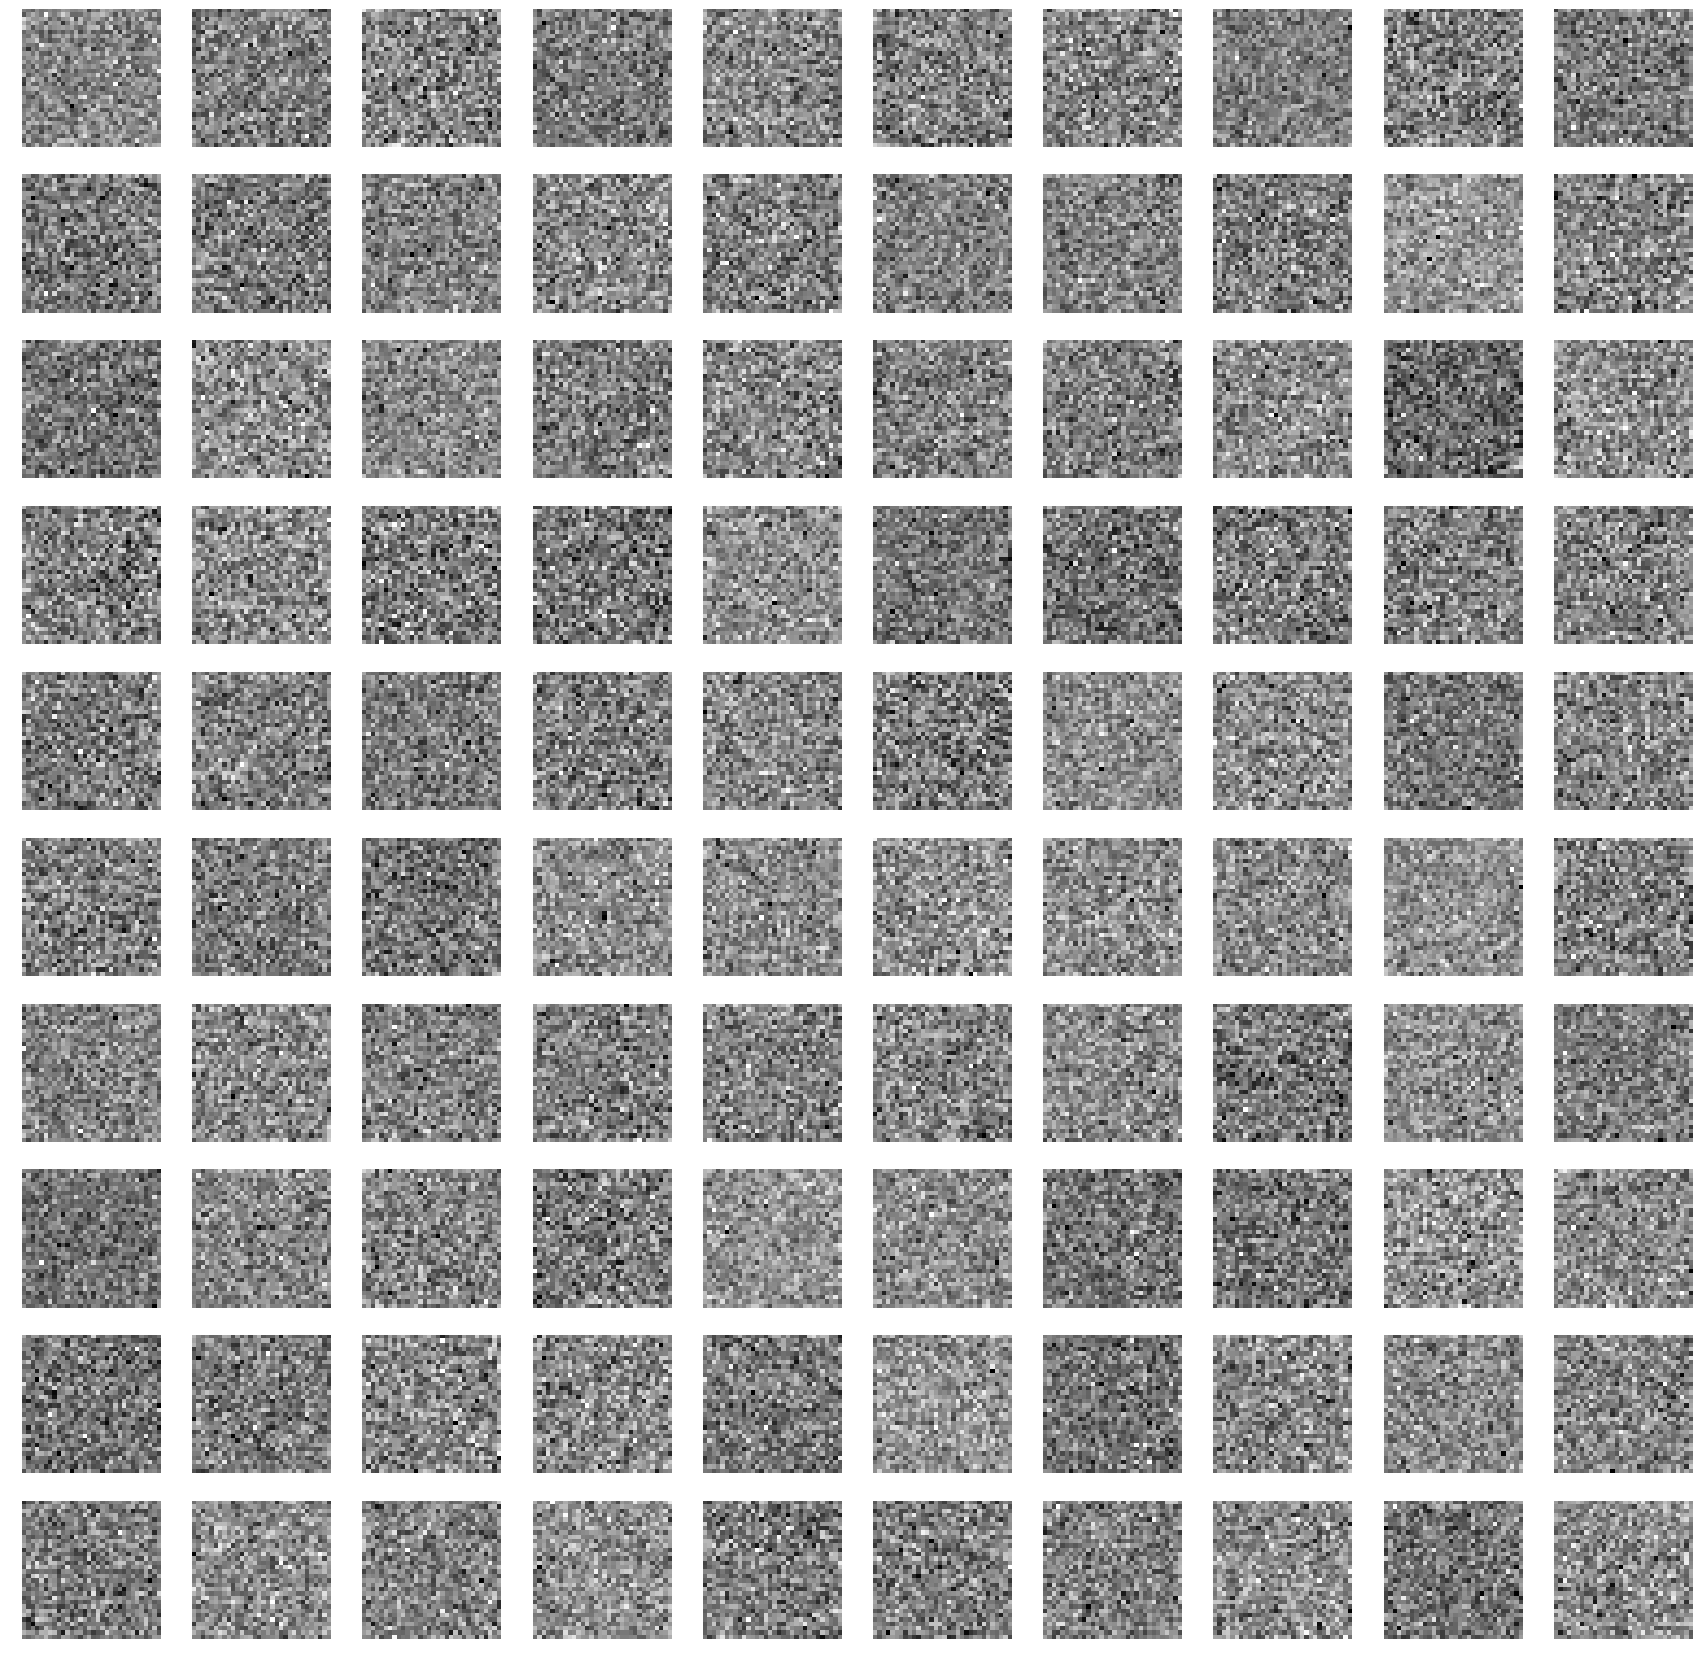

In [347]:
# view
sess_results = sess.run(rice_basis,feed_dict={x:zca_data_reshape.T})
view_result = sess_results.reshape(32,32,400)
fig=plt.figure(figsize=(30, 30))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(view_result[:,:,i-1],cmap='gray')
plt.show()

(1, 4096)


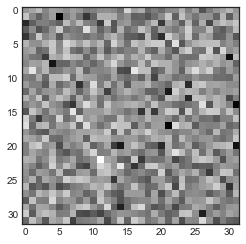

In [348]:
# 
ten_image = zca_data_reshape[:1]
print(ten_image.shape)
ten_basis = sess.run(rice_basis,feed_dict={x:ten_image.T})
plt.imshow(ten_basis.reshape(32,32))
plt.show()

(1024, 4096)


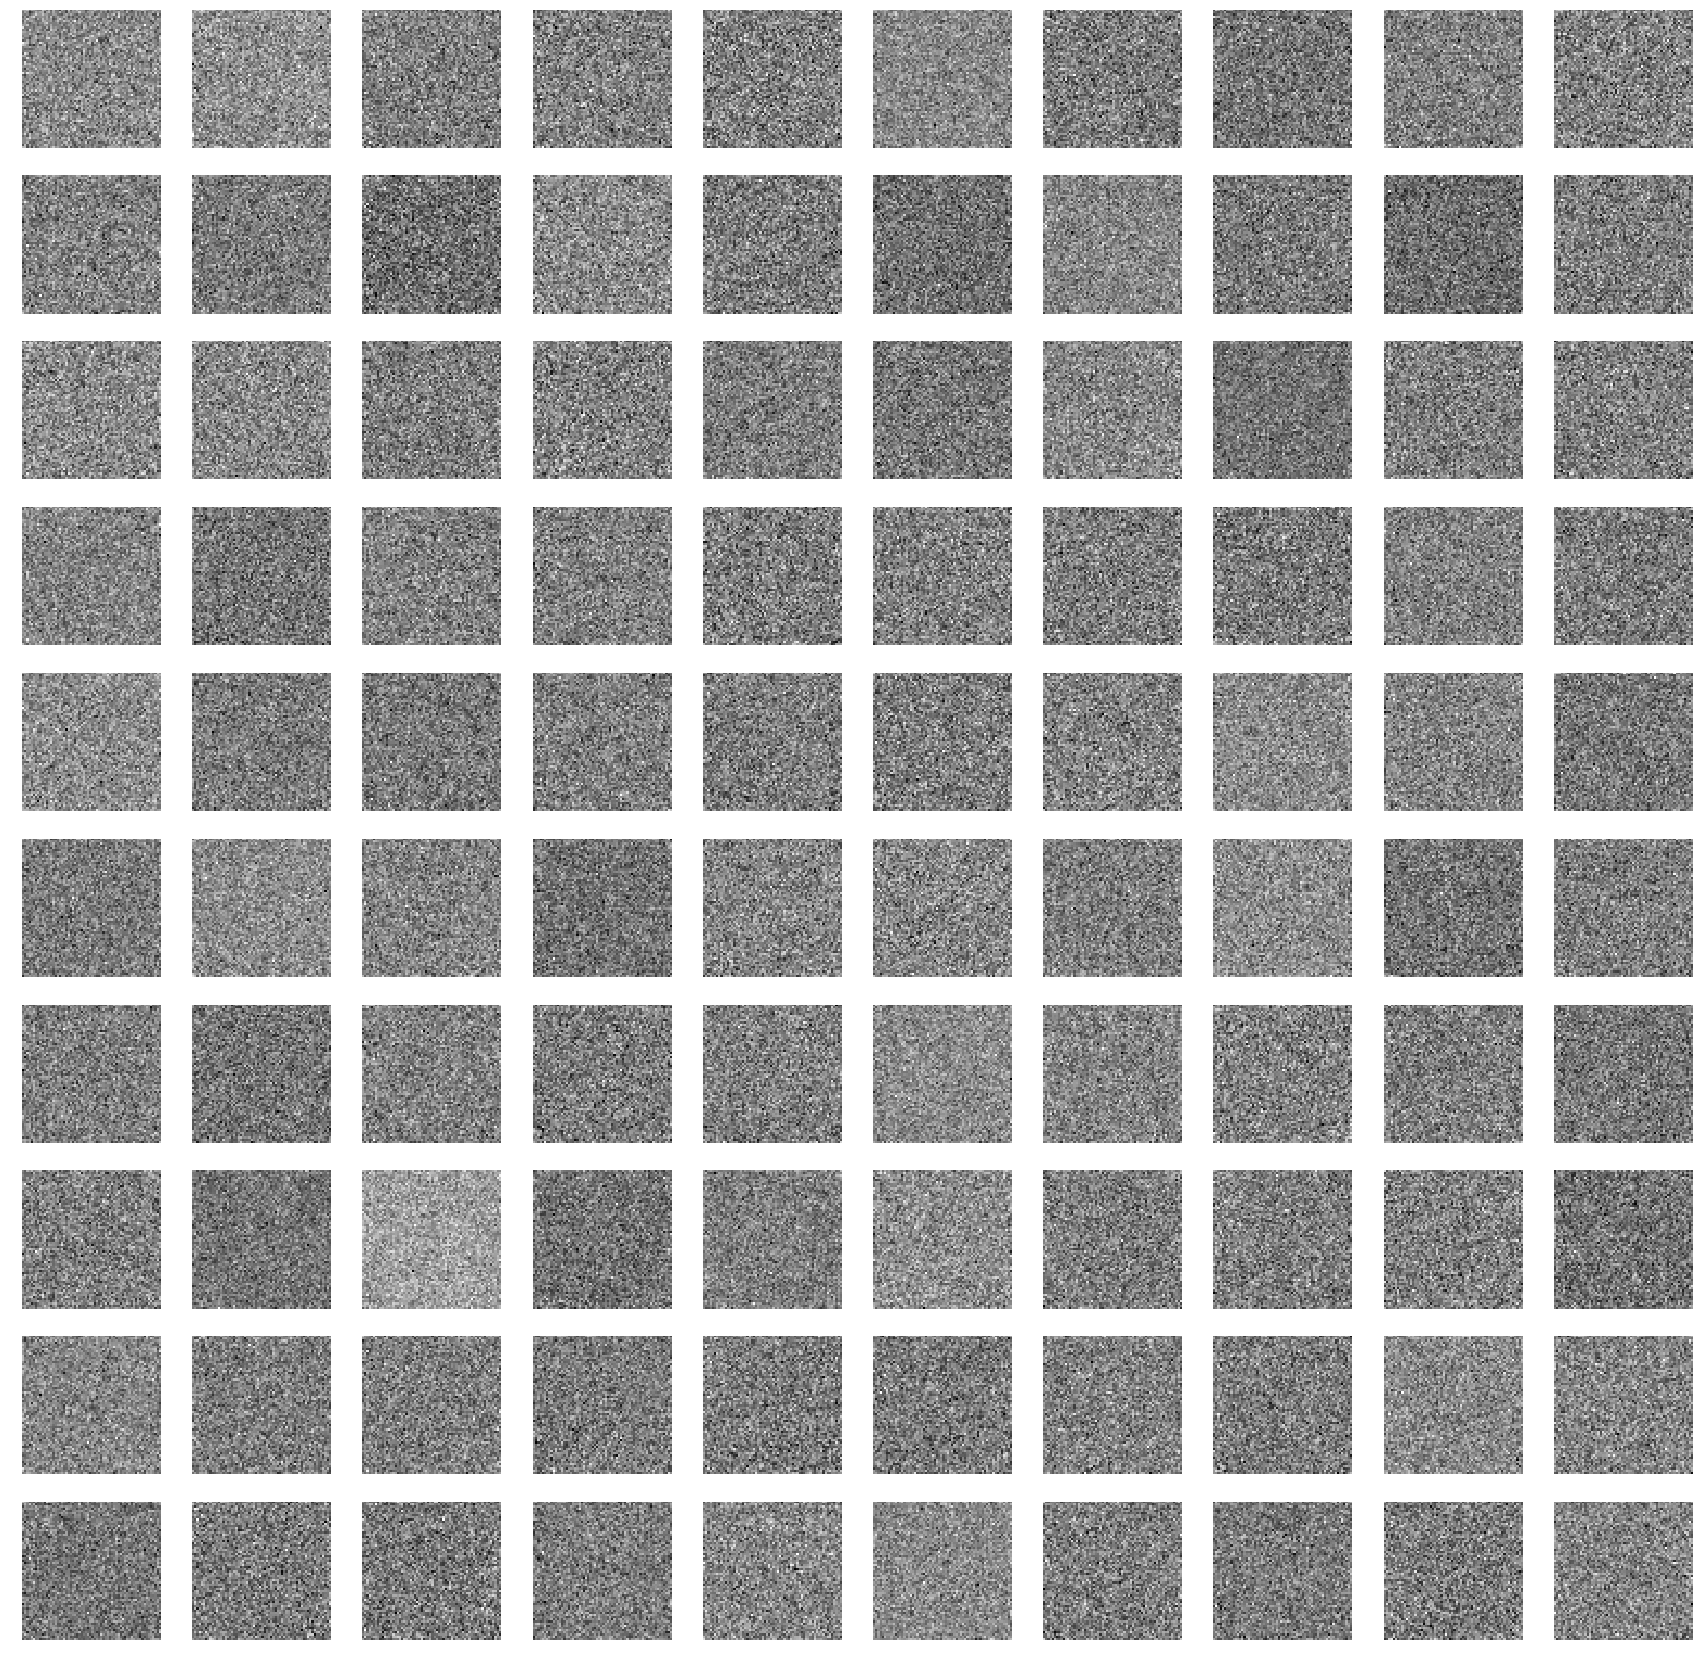

In [349]:
# weights
learned_w = sess.run(rica.getw())
print(learned_w.shape)
learned_w_shape = learned_w.reshape(1024,64,64)
fig=plt.figure(figsize=(30, 30))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(learned_w_shape[i-1],cmap='gray')
plt.show()

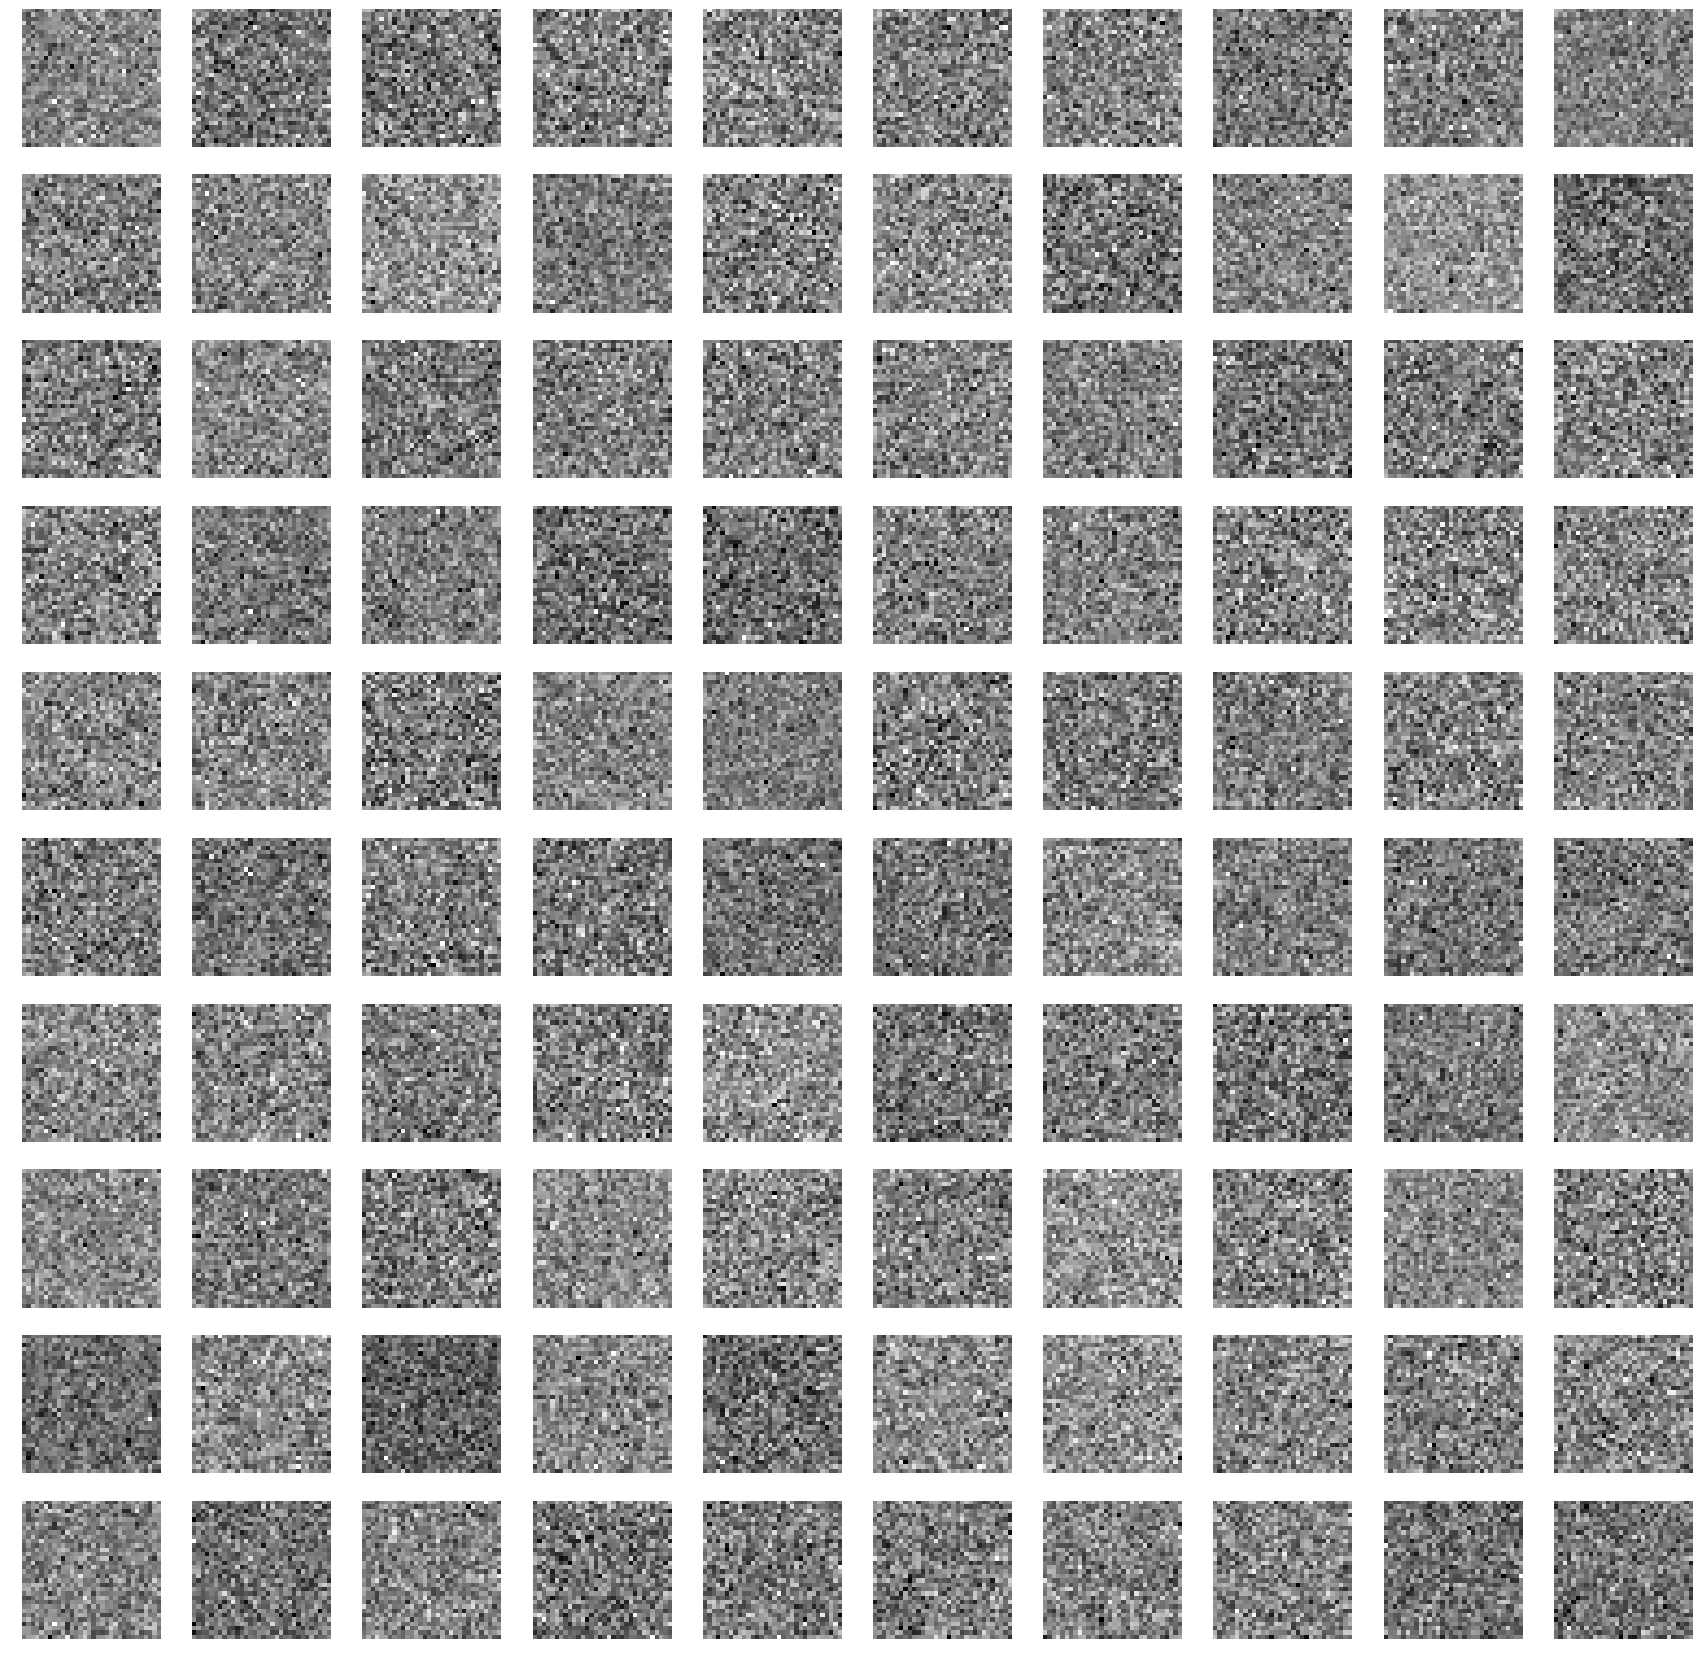

In [350]:
learned_w_shape = learned_w.reshape(32,32,4096)
fig=plt.figure(figsize=(30, 30))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(learned_w_shape[:,:,i-1],cmap='gray')
plt.show()

(400, 64, 64)
(64, 64)


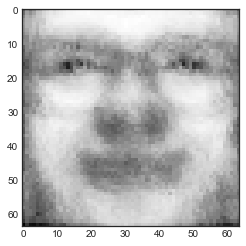

In [355]:
print(train_data.shape)
temp = zca_data.std(0)
print(temp.shape)
plt.imshow(temp)
plt.show()

In [366]:
from sklearn.decomposition import FastICA

compoent = 100
ffast = FastICA(n_components =100,whiten=True)
what_is = ffast.fit_transform(train_data.reshape(400,-1).T)
print(what_is.shape)

(4096, 100)


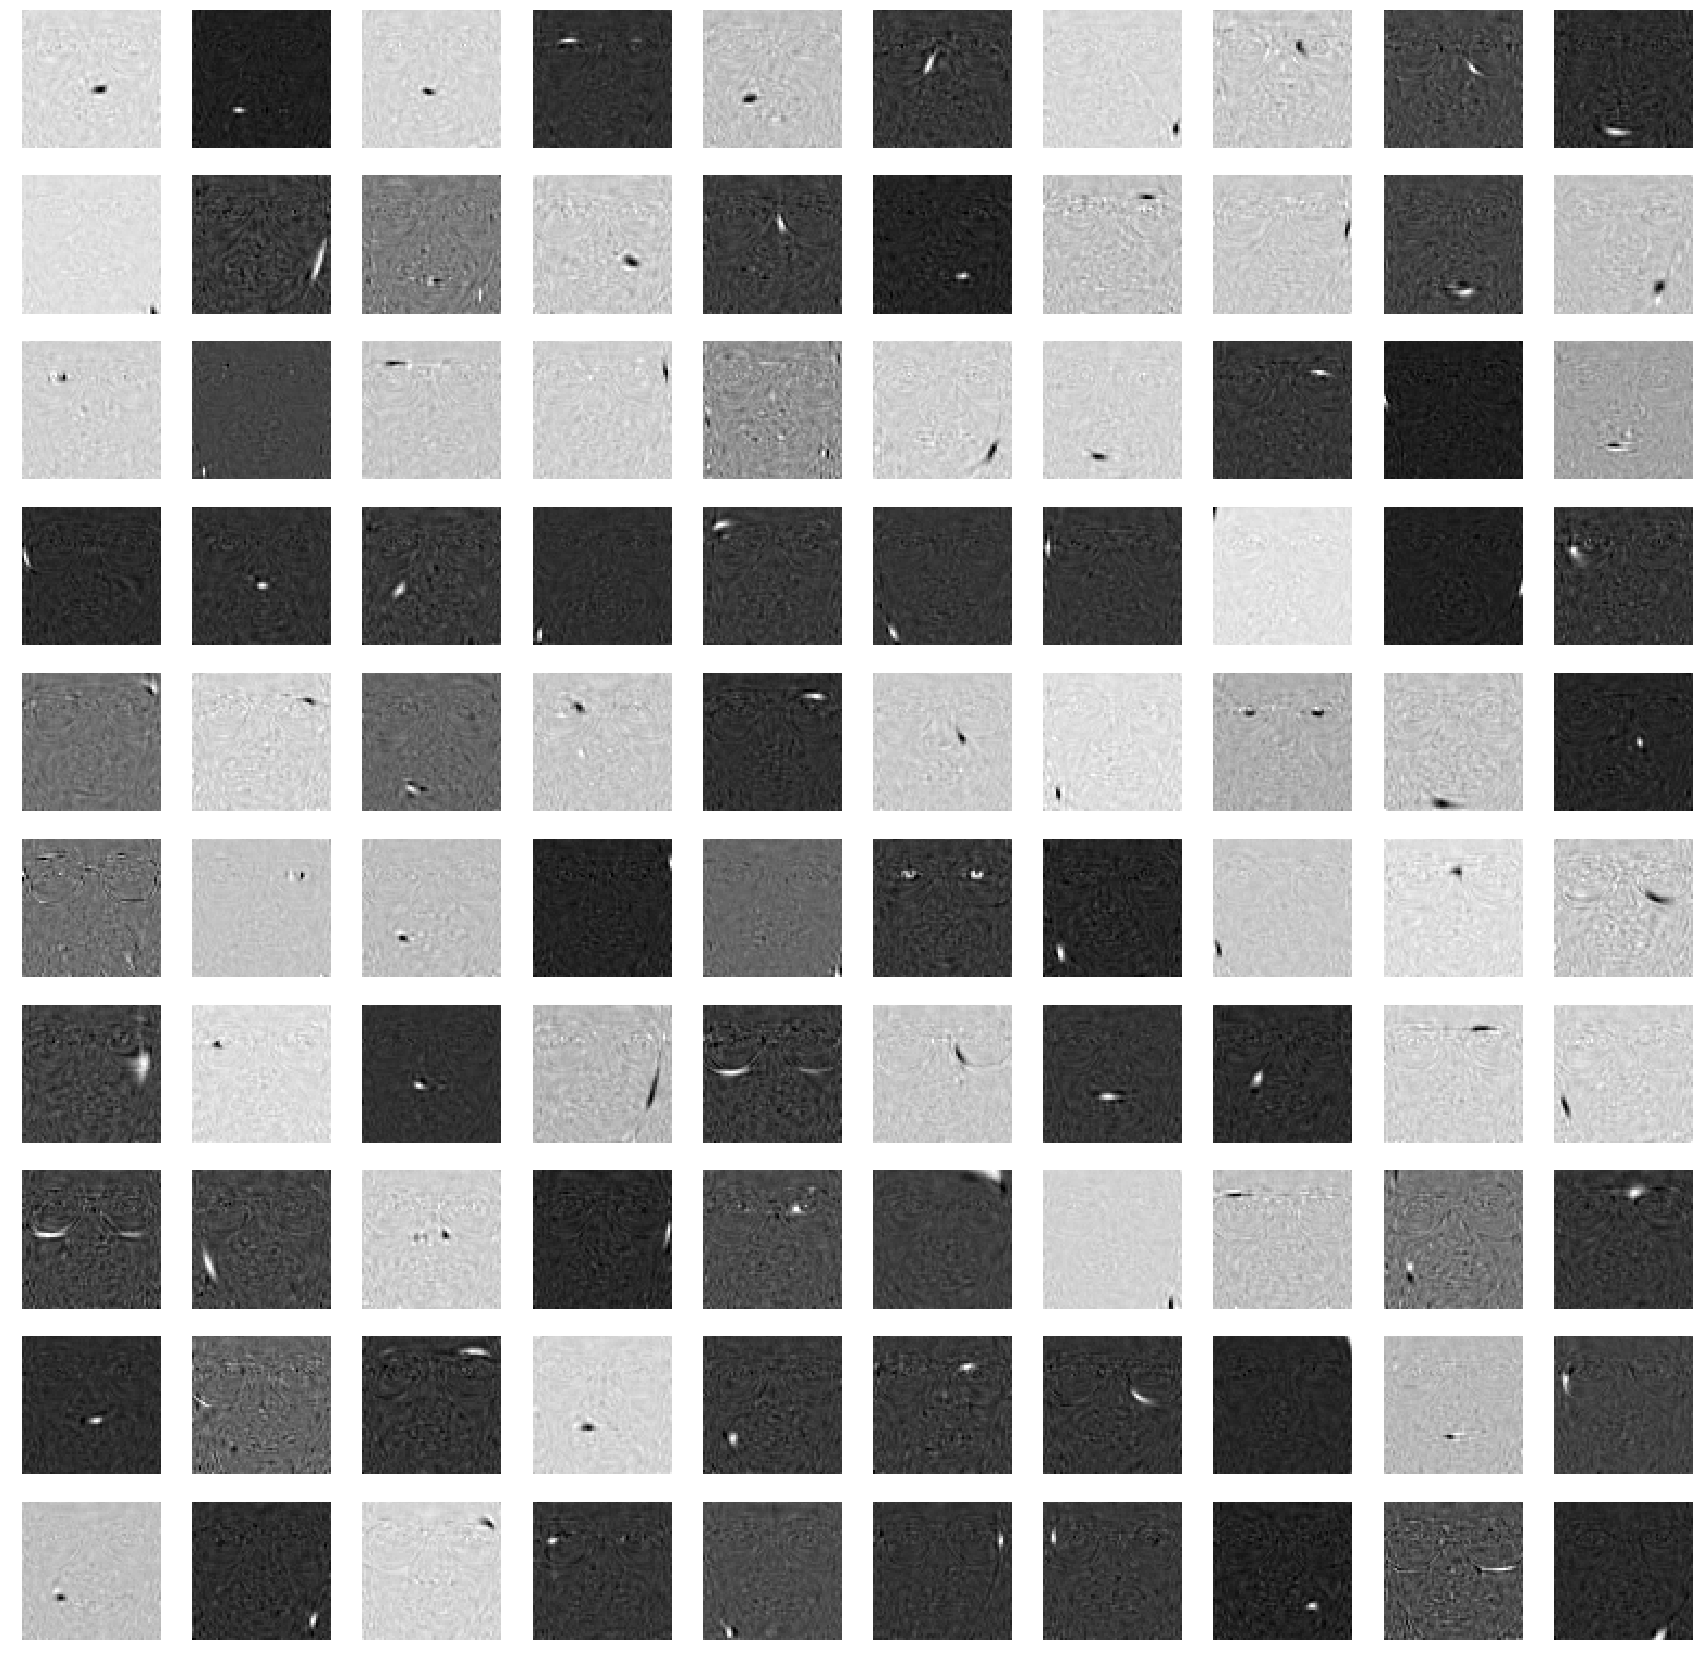

In [361]:
fig=plt.figure(figsize=(30, 30))
what_is = what_is.reshape(64,64,400)
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(what_is[:,:,i-1],cmap='gray')
plt.show()